In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import *
import seaborn as sns
import PIL
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
import os

print("tf Version = ",tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-03-12 15:07:18.733924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741766838.926288     476 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741766838.982365     476 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 15:07:19.452393: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf Version =  2.18.0
Num GPUs Available:  1


In [2]:
batch_size = 32
img_height = 224
img_width = 224
data_dir = 'datasets/dogcat/'

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2003 files belonging to 2 classes.
Using 1603 files for training.


I0000 00:00:1741766862.750409     476 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2242 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [4]:
remaining_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2003 files belonging to 2 classes.
Using 400 files for validation.


In [5]:
val_batches = tf.data.experimental.cardinality(remaining_ds) // 2
test_batches = val_batches

In [6]:
val_ds = remaining_ds.take(val_batches)
test_ds = remaining_ds.skip(val_batches)

In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print('ชื่อคลาส: ',class_names)
print('จำนวนคลาส: ',num_classes)

ชื่อคลาส:  ['cats', 'dogs']
จำนวนคลาส:  2


2025-03-12 15:07:54.533150: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(32, 224, 224, 3)
(32,)


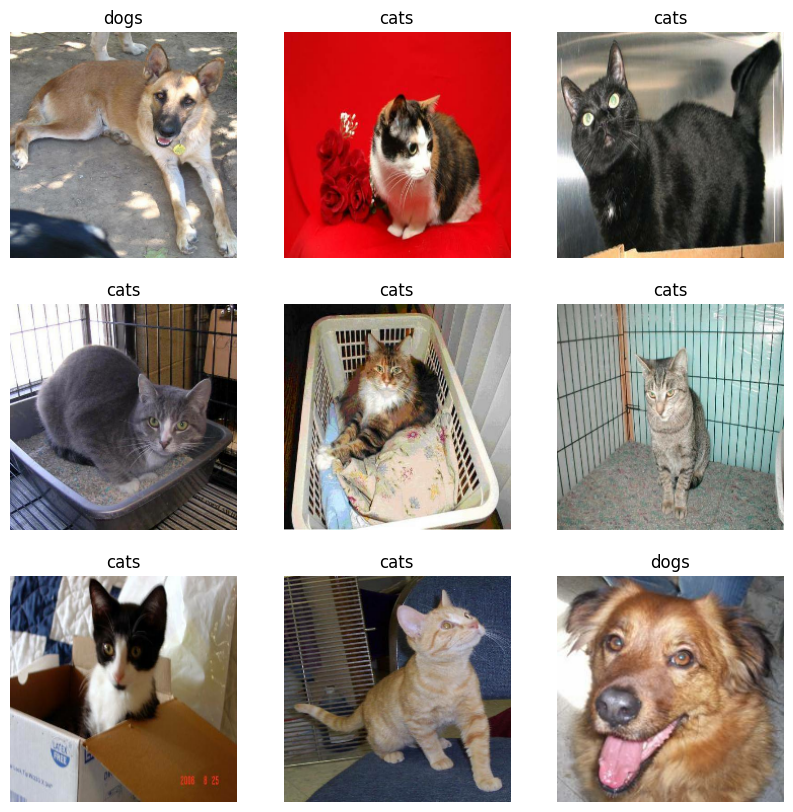

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./224)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.0050821113


In [12]:
# จำนวนคลาสในงานจำแนกประเภท
num_classes = len(class_names)
# สร้าง input layer สำหรับรูปภาพขนาด (img_height, img_width, 3)
inputs = Input(shape=(img_height, img_width, 3))

base_model = MobileNetV2(weights='imagenet', include_top=False)
base_model.trainable = False  # Freeze layers ของ EfficientNetB0

x = base_model(inputs, training=False)
# x = Flatten()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x) # Output layer สำหรับจำแนกจำนวนคลาส

# สร้างโมเดลโดยกำหนด inputs และ outputs
model = Model(inputs=inputs, outputs=outputs)
# คอมไพล์โมเดล
model.compile(optimizer='adamw',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/tmp/ipykernel_476/2139832162.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,639,394 (10.07 MB)

 Trainable params: 381,346 (1.45 MB)

 Non-trainable params: 2,258,048 (8.61 MB)

In [13]:
model_save_path = 'models/MobileNetV2_Dog_Cat.keras'

epochs = 10
checkpoint = ModelCheckpoint(
    filepath=model_save_path,  # ตำแหน่งไฟล์
    monitor='val_loss',       # เมตริกที่ใช้ในการตรวจสอบ (เช่น val_loss หรือ val_accuracy)
    save_best_only=True,      # บันทึกเฉพาะโมเดลที่ดีที่สุด
    save_weights_only=False,  # บันทึกทั้งโมเดล (ไม่ใช่แค่ weights)
    mode='min',               # เลือกโมเดลที่มีค่าต่ำสุดสำหรับ val_loss
    verbose=1                 # แสดงข้อความเมื่อบันทึก
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint]
)

Epoch 1/10


I0000 00:00:1741766920.586847     790 service.cc:148] XLA service 0x7fbb8c002440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741766920.587762     790 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-03-12 15:08:41.207314: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741766922.901114     790 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-12 15:08:49.316793: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1280,7,7]{3,2,1,0}, f32[32,1280,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_con

17/51 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.7843 - loss: 0.4608 

2025-03-12 15:09:00.725425: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[3,32,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,1280,7,7]{3,2,1,0}, f32[32,1280,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8760 - loss: 0.2961 

2025-03-12 15:09:10.163261: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1280,7,7]{3,2,1,0}, f32[32,1280,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}



Epoch 1: val_loss improved from inf to 0.06188, saving model to models/MobileNetV2_Dog_Cat.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 381ms/step - accuracy: 0.8773 - loss: 0.2936 - val_accuracy: 0.9740 - val_loss: 0.0619
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9857 - loss: 0.0517
Epoch 2: val_loss did not improve from 0.06188
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9857 - loss: 0.0516 - val_accuracy: 0.9688 - val_loss: 0.0914
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9945 - loss: 0.0254
Epoch 3: val_loss did not improve from 0.06188
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9945 - loss: 0.0253 - val_accuracy: 0.9688 - val_loss: 0.1008
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9991 - loss: 0.0074
Epoch 4: val_loss did not improve from 0.06188
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9990 - loss: 0.0074 - val_accuracy: 0.9740 - val_loss: 0.1061
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s

In [14]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_accuracy:.4f}")

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9689 - loss: 0.1520 

2025-03-12 15:09:57.075895: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,32,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1280,7,7]{3,2,1,0}, f32[32,1280,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9707 - loss: 0.1423  

Test accuracy: 0.9760


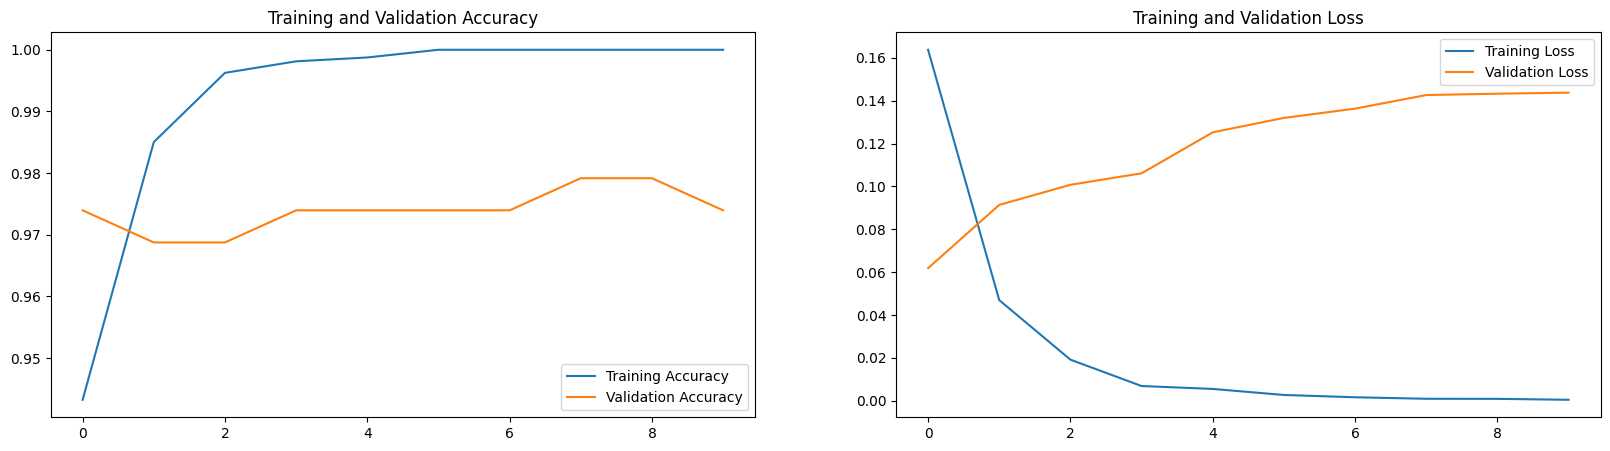

In [15]:
os.makedirs('validpic', exist_ok=True)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('validpic/training_vs_validation.png')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 921ms/step


2025-03-12 15:10:31.426521: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


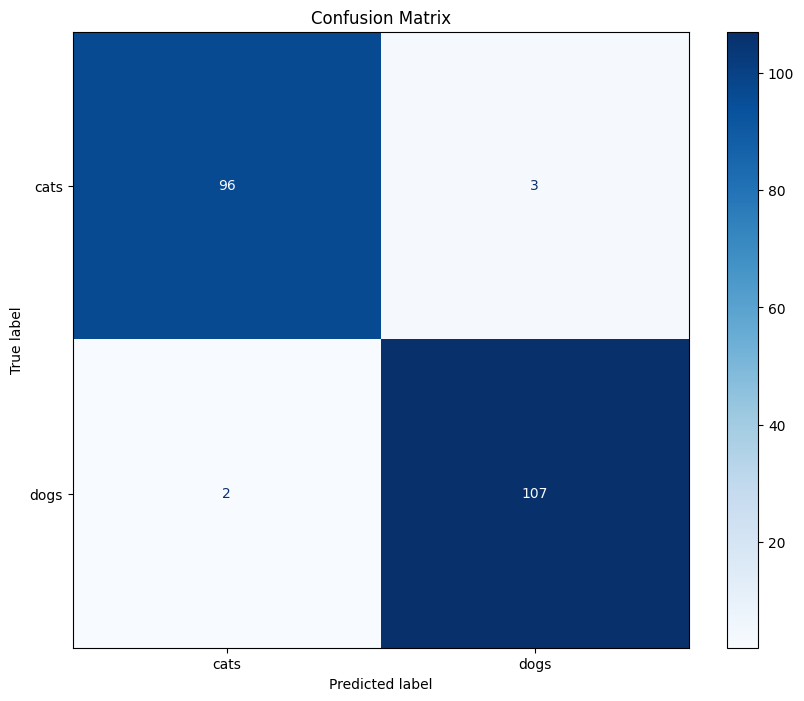

In [16]:
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)


y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)


cm = confusion_matrix(y_true, y_pred_classes)


fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('validpic/confusion_matrix.png')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step 


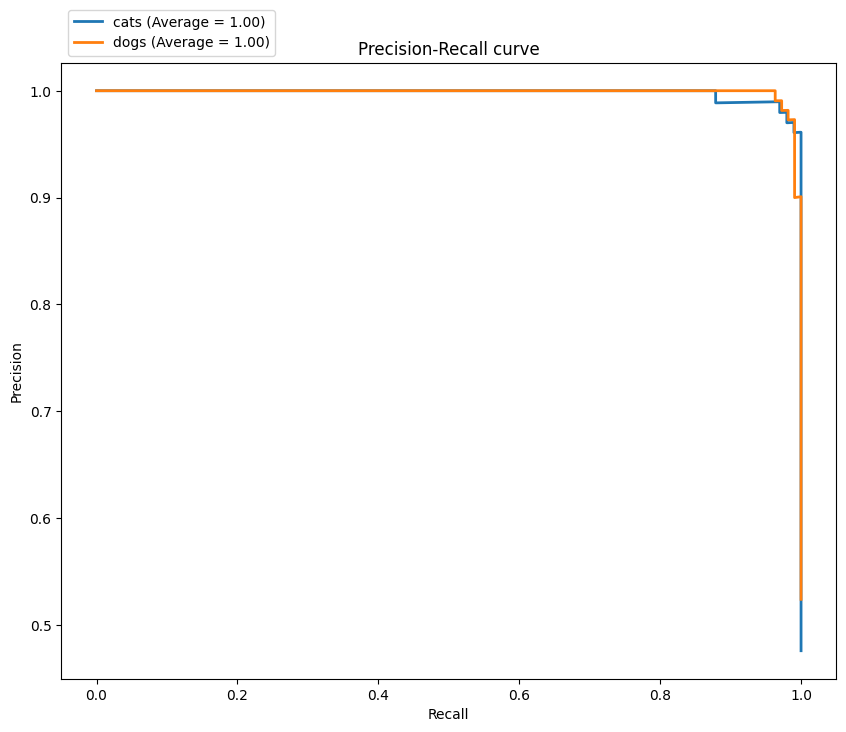

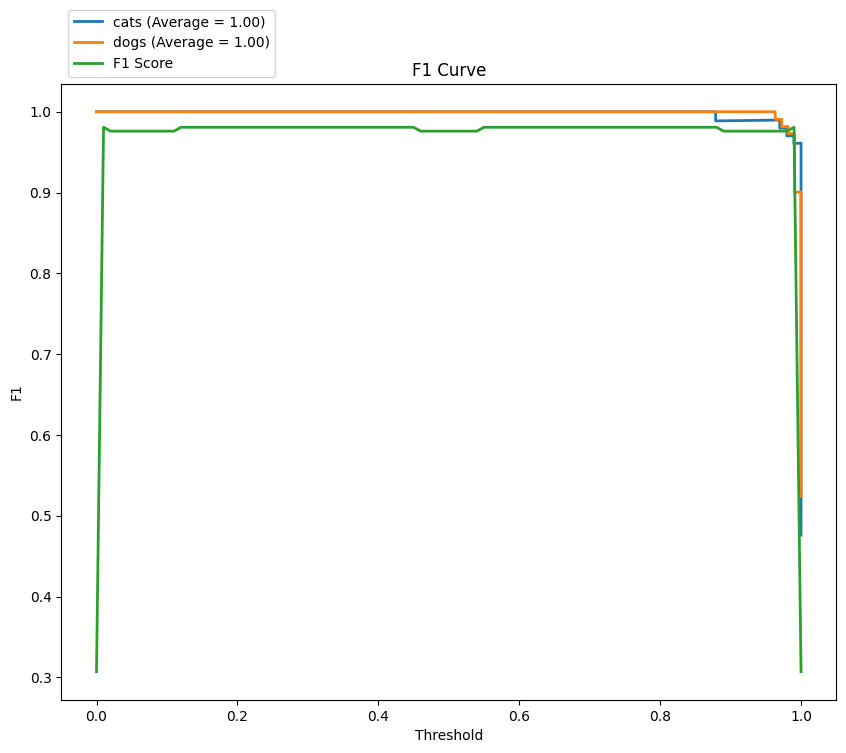

In [17]:
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)


precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_pred[:, i])


plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'{class_names[i]} (Average = {average_precision[i]:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.legend(loc='lower left', bbox_to_anchor=(0, 1))
plt.savefig('validpic/precision_recall_curve.png')
plt.show()


f1 = []
thresholds = np.linspace(0,1,101)
for t in thresholds:
    f1_t = f1_score(y_true, (y_pred > t).argmax(axis=1), average="weighted")
    f1.append(f1_t)

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'{class_names[i]} (Average = {average_precision[i]:.2f})')
plt.plot(thresholds, f1, lw=2, label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("F1 Curve")


plt.legend(loc='lower left', bbox_to_anchor=(0, 1))
plt.savefig('validpic/f1_curve.png')
plt.show()